In [40]:
#!pip install botorch
#!pip install pyDOE
#!pip install openpyxl
#!pip install smt
#!pip install scikit-optimize

In [41]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs



In [42]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
#from botorch.transforms import Standardize
#from botorch.utils.transforms import euclidean_distance
from botorch.acquisition.analytic import PosteriorStandardDeviation



In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


#Generate points

#import data

# Inputs

check the sampling file

# Outputs

In [44]:
from PNNL_spectra_extract import data_102119
#data_102119.head(16)[['time','temp','analyte','yield product']]
# /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
# %run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

In [45]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


In [46]:
std_data = data_102119.groupby('time').std().reset_index()[['time','temp','sulf','analyte','yield product']]
std_data

,time,temp,sulf,analyte,yield product
0,49,0.0,0.0,0.0,0.002110
1,87,0.0,0.0,0.0,0.007884
2,125,0.0,0.0,0.0,0.011663
3,163,0.0,0.0,0.0,0.142828
4,201,0.0,0.0,0.0,0.008250
5,239,0.0,0.0,0.0,0.010353
6,277,0.0,0.0,0.0,0.005608
7,315,0.0,0.0,0.0,0.025185
8,353,0.0,0.0,0.0,0.001016
9,391,0.0,0.0,0.0,0.000763


# Start of BO

In [47]:
# Modify the objective function to minimize the L2 distance between the predicted and reference RGB values
def quary(predicted_composition,pool_y,pool_x):
    vector_y = []
    vector_x = []
    id = []
    # Reference RGB value (the desired or ideal RGB you want to achieve)
    #desired_composition = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=dtype)
    # Calculate the Euclidean distance between measured and desired compositions
    #distance_ref = desired_composition - predicted_composition #d2 = cand-reference

    for i in range(len(predicted_composition)):
        pool_distance = torch.norm(predicted_composition[i]-pool_x,dim=1)

        vector_y.append(pool_y[pool_distance.argmin()])
        vector_x.append(pool_x[pool_distance.argmin()])

        indices_to_remove = pool_distance.argmin()
        # Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
        mask = torch.ones(pool_x.size(0), dtype=torch.bool)
        mask[indices_to_remove] = 0

        # Use the mask to select elements from the tensor
        pool_y = pool_y[mask]
        pool_x = pool_x[mask]

        #id.append(torch.norm(pool_distance,dim=1).argmin().item())

    vector_y = np.array([element for element in vector_y])
    vector_x = np.array([element for element in vector_x])
    #d_pool =  torch.abs(pool_y - predicted_composition).mean(axis=1)
    #actual = actual_pool[distance]
    #candidate = actual_candidates[distance]
    return torch.tensor(vector_y),torch.tensor(vector_x),pool_y, pool_x 


https://distill.pub/2020/bayesian-optimization/ ||
https://github.com/pytorch/botorch/issues/546 || 
Reference: https://gist.github.com/danhphan/af53fb7958a28c2e2d514221ea83bd9c





In [48]:
def prediction(cand_eval,model):
    with torch.no_grad():
        posterior = model.posterior(cand_eval)
        mean = posterior.mean
        variance = posterior.variance
        return mean,variance

In [49]:
def BO_pool(acq_func,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool):
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=train_size,
        raw_samples=100,
        options={"dtype": dtype, "device": device}
    )

    ## Find the values closest to the candidates in the data pool
    new_val = quary(candidate,y_pool,x_pool) #torch.tensor(objective(candidate), dtype=torch.float32).reshape(len(objective(candidate)),1)
    new_x = new_val[1] # closest x val to the candidate
    new_y = new_val[0] # closest y val to the candidate (determined by pool y vs pool x pair)

    train_x = torch.cat([train_x,  new_x ]) 
    train_y = torch.cat([train_y,  new_y ])

    y_pool = new_val[2]
    x_pool = new_val[3]

    ## Update the gaussian model
    gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    return candidate, train_x, train_y, y_pool, x_pool, gp_model



In [50]:
## Setting up the data
x = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)
#reference = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=torch.float32) ##??
# x = torch.tensor([data_102119['time'],data_102119['temp'],data_102119['sulf'],data_102119['analyte']],dtype=torch.float32).T#[:48]
# y = torch.tensor(data_102119['yield product'],dtype=torch.float32).reshape(-1,1)

train_size = 2
rand_id = []
for n in range(20):
    np.random.seed(n)
    random_id = np.random.choice(y.shape[0], size=train_size, replace=False)
    rand_id.append(random_id)

# test_x = torch.tensor(x[rand_id[0]], dtype=dtype).to(device=device, dtype=dtype)
# test_y = torch.tensor(y[rand_id[0]], dtype=dtype)

# test_x, test_y,rand_id[0]

bounds = torch.tensor([[0., 0., 0.,0.], [600., 145., 100.,100.]], dtype=dtype, device=device)
batch_size = 1 #train_size

iteration_number=(len(avg_data)-train_size)//batch_size
iterations = list(range(0, iteration_number+1))#list(range(1, iteration_number+1))


In [51]:
## All EI
# Set up training 
train_x = torch.tensor(x[random_id], dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y[random_id], dtype=dtype)

indices_to_remove = random_id 
## Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
mask = torch.ones(y.size(0), dtype=torch.bool)
mask[indices_to_remove] = 0
y_pool = y[mask] #93 exclude training data
x_pool = x[mask] #93 exclude training data


## Create the surrogate model
gp_model1 = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model1.likelihood, gp_model1)
fit_gpytorch_model(mll)

mean1,variance1 = prediction(train_x,gp_model1)

# Start of the BO loops
iter_UCB = 0
iter_EI = iteration_number-iter_UCB

means_EI = []
variances_EI = []
# for i in range(iter_UCB):
#     ## Define aquisition functions
#     UCB = UpperConfidenceBound(model=gp_model1, beta=0.1)

#     # run pool BO for three iterations using UCB
#     candidate, train_x, train_y, y_pool, x_pool, gp_model1 = BO_pool(UCB,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
#     mean,variance = prediction(candidate,gp_model1)
#     means_EI.append(mean.numpy().item())
#     variances_EI.append(variance.numpy().item())
    
# swtich to EI
for i in range(iter_EI):
    ## Define aquisition functions
    #EI = ExpectedImprovement(model=gp_model1, best_f=0.95)
    PV = PosteriorStandardDeviation(model=gp_model1)
    # run pool BO for three iterations using UCB
    candidate, train_x, train_y, y_pool, x_pool, gp_model1 = BO_pool(PV,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
    mean,variance = prediction(candidate,gp_model1)
    means_EI.append(mean.numpy().item())
    variances_EI.append(variance.numpy().item())
    


In [52]:
## All UCB
# Set up training 
train_x = torch.tensor(x[random_id], dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y[random_id], dtype=dtype)

indices_to_remove = random_id 
## Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
mask = torch.ones(y.size(0), dtype=torch.bool)
mask[indices_to_remove] = 0
y_pool = y[mask] #93 exclude training data
x_pool = x[mask] #93 exclude training data


## Create the surrogate model
gp_model2 = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model2.likelihood, gp_model2)
fit_gpytorch_model(mll)

mean2,variance2 = prediction(train_x,gp_model2)

# Start of the BO loops
iter_UCB = iteration_number
#iter_EI = iteration_number-iter_UCB

means_UCB = []
variances_UCB = []
for i in range(iter_UCB):
    ## Define aquisition functions
    UCB = UpperConfidenceBound(model=gp_model2, beta=0.1)

    # run pool BO for three iterations using UCB
    candidate, train_x, train_y, y_pool, x_pool, gp_model2 = BO_pool(UCB,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
    mean,variance = prediction(candidate,gp_model2)
    means_UCB.append(mean.numpy().item())
    variances_UCB.append(variance.numpy().item())
    
# swtich to EI
# for i in range(iter_EI):
#     ## Define aquisition functions
#     EI = ExpectedImprovement(model=gp_model1, best_f=0.95)

#     # run pool BO for three iterations using UCB
#     candidate, train_x, train_y, y_pool, x_pool, gp_model1 = BO_pool(EI,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
#     mean,variance = prediction(candidate,gp_model1)
#     means_EI.append(mean.numpy().item())
#     variances_EI.append(variance.numpy().item())
    


In [53]:
## UCB + EI
# Rerun the train to set back up
train_x = torch.tensor(x[random_id], dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y[random_id], dtype=dtype)

indices_to_remove = random_id 
## Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
mask = torch.ones(y.size(0), dtype=torch.bool)
mask[indices_to_remove] = 0
y_pool = y[mask] #93 exclude training data
x_pool = x[mask] #93 exclude training data

## Create the surrogate model
gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

mean,variance = prediction(train_x,gp_model)

# Start of the BO loops
iter_UCB = 3
iter_EI = iteration_number-iter_UCB

means_UCBEI = []
variances_UCBEI = []
for i in range(iter_UCB):
    ## Define aquisition functions
    UCB = UpperConfidenceBound(model=gp_model, beta=0.1)

    # run pool BO for three iterations using UCB
    candidate, train_x, train_y, y_pool, x_pool, gp_model = BO_pool(UCB,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
    mean,variance = prediction(candidate,gp_model)
    means_UCBEI.append(mean.numpy().item())
    variances_UCBEI.append(variance.numpy().item())
    
# swtich to EI
for i in range(iter_EI):
    ## Define aquisition functions
    EI = ExpectedImprovement(model=gp_model, best_f=0.95)

    # run pool BO for three iterations using UCB
    candidate, train_x, train_y, y_pool, x_pool, gp_model = BO_pool(EI,train_size,batch_size,bounds,train_x,train_y, y_pool, x_pool)
    mean,variance = prediction(candidate,gp_model)
    means_UCBEI.append(mean.numpy().item())
    variances_UCBEI.append(variance.numpy().item())
    

In [54]:
means_UCBEI  = np.array([element for element in means_UCBEI ])
variances_UCBEI  = np.array([element for element in variances_UCBEI])
means_EI  = np.array([element for element in means_EI ])
variances_EI  = np.array([element for element in variances_EI])
means_UCB  = np.array([element for element in means_UCB])
variances_UCB  = np.array([element for element in variances_UCB])
variances_UCBEI 

array([0.37223995, 0.25652185, 0.20315513, 0.1578902 , 0.13864873,
       0.24535671, 0.17708658, 0.15775943, 0.14120491, 0.13240324,
       0.08868632, 0.10397521, 0.13262808])

Text(0.5, 1.0, 'Variance')

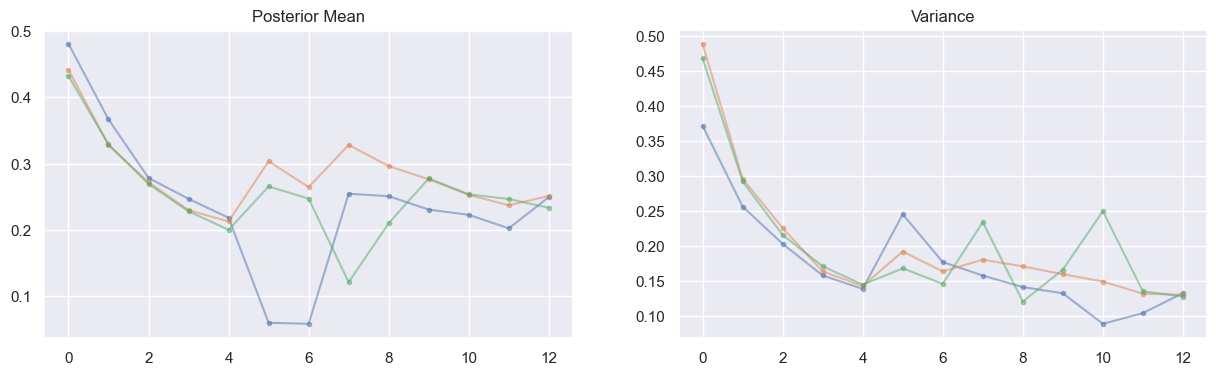

In [60]:
alpha = 0.5
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(means_UCBEI,'.-',alpha =alpha )
plt.plot(means_EI,'.-',alpha =alpha )
plt.plot(means_UCB,'.-',alpha =alpha )

plt.title('Posterior Mean')

plt.subplot(1,2,2)
plt.plot(variances_UCBEI ,'.-',alpha =alpha )
plt.plot(variances_EI ,'.-',alpha =alpha )
plt.plot(variances_UCB ,'.-',alpha =alpha )
plt.title('Variance')
    


# plots

In [56]:
def surface_all(ax,data_temp,input1,input2,output,color):
        # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    #Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    #ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.plot_surface(X, Y, Z,alpha= 0.3,color=color)
 
    #ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)
    ax.set_zlabel('output')

In [57]:
def contour_all(ax,data_temp,input1,input2,output,color):
    # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    #Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    #ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.contour(X, Y, Z,8,alpha= 0.3,colors=color)
    #ax.contourf(X, Y, Z, 8, alpha=.5) # plt.contourf(X, Y, f(X, Y), 8, alpha=.75, cmap=plt.cm.hot)
    #C = ax.contour(X, Y, Z, 8, colors='black', linewidth=.25,linstlyle = '--') # C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
    #ax.clabel(C, inline=1, fontsize=1)


    #ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)


In [58]:
def min_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]<= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

def max_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]>= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

# Benchmarking

# Clustering